<a href="https://colab.research.google.com/github/kriaz100/deep-learning-with-python-notebooks/blob/master/chapter11_part01_introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for text

https://ufal.mff.cuni.cz/udpipe/2/models

## Natural-language processing: The bird's eye view

## Preparing text data

### Text standardization

### Text splitting (tokenization)

### Vocabulary indexing

### Using the TextVectorization layer
- The Vectorizer class defined below has several methods: standardize, tokenize, make_vocabulary, encode, and decode. 

- These methods can be called on a dataset to perform standardization, tokenization, vocabulary indexing etc.

In [2]:
import string

class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

vectorizer = Vectorizer()
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
vectorizer.make_vocabulary(dataset)

In [3]:
# encoding a sentence
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

[2, 3, 5, 7, 1, 5, 6]


In [4]:
# Decoding a sentence
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


In practce, we use Keras <font color ='blue'>**`TextVectorization`** layer </font> instead of programming everything from scratch in python

- The `TextVectorization` layer below is configured to return sequences of words encoded as integers indices (output_mode is set to 'int').

- The layer will do the following:
    - *standardization*: convert text to lowercase and remove punctuation
    - *tokenization*: split on white space

In [5]:

from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    output_mode="int",
)

The Keras `TextVectorization` layer is flexible enough to handle any  use case for standardization, or tokenization because it can incorporate **custom funtions for standardization and tokenization** (as shown below).

In [ ]:
import re
import string              
import tensorflow as tf

# define custom standardization function
def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor) #convert string_tensors to lowercase
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "") #replace punctuation w empty string

# define custom tokenization function (for splitting)
def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

# incorporate custom standardization and tokenization fns into TextVectorization layer
text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

Apply `TextVectorization` layer

- To index the vocabulary of a text corpus, call the `adapt()` method of the `TextVectorization` layer with a dataset object that yields strings.

- The vocabulary for the layer must be either supplied on construction <font color='blue'>or learned via adapt()</font>. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a vocabulary from them.

In [1]:
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
text_vectorization.adapt(dataset)

NameError: ignored

**Displaying the vocabulary**

In [ ]:
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'erase',
 'write',
 'then',
 'rewrite',
 'poppy',
 'i',
 'blooms',
 'and',
 'again',
 'a']

Displaying the **vocabulary of a test sentence** using `TextVectorization` layer

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)

tf.Tensor([ 7  3  5  9  1  5 10], shape=(7,), dtype=int64)


In [ ]:
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


IMPORTANT NOTE

`TextVectorization` layer can't be executed on GPU (or TPU). This has implications for model training (see **SIDEBAR** in the book).

## Two approaches for representing groups of words: <font color='blue'>Sets and sequences</font>

### Preparing the IMDB movie reviews data

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  26.9M      0  0:00:02  0:00:02 --:--:-- 26.9M


In [ ]:
!rm -r aclImdb/train/unsup

In [ ]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

Preparing a validation set by setting apart 20% of the training text files in a new directory, **aclImdb/val**

In [ ]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

# moving 20% files from  training and validation directory
# I added argument exist_ok=True to os.makedirs() to avoid error in case
#  dir exists already 
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)  #adding 'exist_ok=True'
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

Using text_dataset_from_directory to create batched dataset of text files and their labels for a directory structure. This is similar to the utility, image_dataset_from_dircetory, which was used for image files in chapter 8.

In [ ]:
from tensorflow import keras
batch_size = 32                     #choice of batch size

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Displaying the shapes and dtypes of the first batch**

These datasets yield inputs that are <font color='blue'>TensorFlow tf.string tensors</font>, and targets that are <font color='blue'>int32 tensors</font> encoding the value "0" or "1"

In [ ]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'Alright, I got passed the horrible acting. I got passed the fact that Lil Kim was blasting some cannons and her arms or hands weren\'t moving, I got passed the weaves, I got passed the colored contacts.<br /><br />This is what killed it for me: In the scene where the four roses were sitting at the table arguing. Lisa-Raye and Monica Calhoun stand up and, and then Lil Kim gets up to break up any hostilities by saying, "Whoa, Whoa, Whoa, Hold up. Let\'s CHILL OUT here for a HOT SECOND." I am a fan of the western movie genre, and I never heard anyone talk slang like this in any of Clint Eastwood\'s movies.<br /><br />If anyone thinks this movie deserves over a 1 rating, please tell me another movie that\'s worse than Gang of Roses.<br /><br />I\'m through.', shape=(), dtype=string)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


### Processing words as a set: The bag-of-words approach
The simplest way to encode a piece of text for processing by a nmachine model is to discard order and treat it as a set (a "bag") of tokens. You could either look at individual owrds (unigrams), or try to recover some local order information by looking at groups of consecutive tokens (N-grams)

#### Single words (unigrams) with binary encoding

**Preprocessing our datasets with a `TextVectorization` layer**

The datasets train_ds, val_ds, and test_da were created earlier with keras utility `text_dataset_from_directory`.

We will use `lambda function` to multi-hot encode the text in these datasets. Let's we first go over a toy example of lamba function. 

**Toy example of lambda function: think λ(x)**
1. Suppose, we want to define a function λ(x) which multiplies x by 2, ie. returns 2x. That is, **λ(x)= 2x**.
      
      This is how we will write it in python

      `lambda x: 2x`

2. We want to apply (map) the function λ(x) to all x such that x ϵ A =[1, 2, 3].  

  For this purpose We will use `map()` function.

          map(lambda x: 2x, A)

3. Finally, we want to list all the results y ϵ Y where y = λ(x). We will use  `list()`. The full code is shown below:

  ```
    A =[1, 2, 3]
    Y = list(map(lambda x: 2*x, A))
    print(Y)
  ```
        Output:
        [2, 4, 6]

Recall the `TextVectorization` layer creates the multi-hot encoding with a vocabulary of 20,000 words.

We will apply the `TextVectorization` layer as a `lambda function` on datasets `train_ds`, `val_ds`, and `test_ds`. This will multi-hot encode the text in all these data sets.



<font color='red'>**IMPORTANT**: Must run text vectorization cell above before running the next cell.</font> This was in section *Using TextVectorization layer*, reproduced here easy for references

```
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    output_mode="int",
)

```
Otherwise you will get the error message: 

> "*nameerror: name 'textvectorization' is not defined"*.</font> 

In [ ]:
# defining Keras TextVectorization layer, 
#   specify max_tokens in vocabulary
#   multi-hot encoding. 
#   Default encoding is 1gram. If we want bi-grams then set ngrams=2

# MUST RUN  text_vectorization cell above before running this cell.

text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
)

# Using lambda fn to create text only data sets from train_ds
#    i.e. extracting only feature but no labels from examples.
#    Use that data to index dataset vocabulary, via adapt() method.
#    The vocabulary from text_only_train_ds  will be used in training 
#    bi-gram model in a latter section.

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

# Applying TextVectorization as lambda function
# on features (x) only in each ds to encode 1-grams with max vocab=20,000 words

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**Inspecting the output of our binary unigram dataset**

In [ ]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


**Our model-building utility**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

**Training and testing the binary unigram model**

In [ ]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 11s 16ms/step - loss: 0.4077 - accuracy: 0.8299 - val_loss: 0.2892 - val_accuracy: 0.8836
Epoch 2/10
625/625 [=======================

Got validation accuracy 0.883, and text accuracy 0.885

#### Bigrams with binary encoding

**Configuring the `TextVectorization` layer to return bigrams**
- Some atomic concepts cannot be represented by 1-grams. For example, "United States". The local order information is important in these cases, which may lead to choice of N-grams (usually bi-grams), instad of 1-gram.

- To configure the `TextVectorization` layer to return **bigrams**, specify `ngrams=2` argument in `TextVectorization` layer

<font color='red'>Make sure TextVectorzation layer has been imported before running the next cell</font>.

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2, 
    max_tokens=20000,
    output_mode="multi_hot",
)

**Training and testing the binary bigram model**

- The textVectorization layer defined above creates bi-grams (ngrams=2). 
- The output mode of the layer  is tf-idf. When applied to a text dataset, it will create vocabulary as well as learn the tf-idf weights.  


In [ ]:

text_vectorization.adapt(text_only_train_ds)

binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()                 # model to load to be specified below 
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
# specifying the model to load
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_8 (Dense)             (None, 16)                320016    
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3733 - accuracy: 0.8464 - val_loss: 0.2708 - val_accuracy: 0.8970
Epoch 2/10
625/625 [======================

The bigram model got validation accuracy 0.901 and test accuracy 0.895

Recall that the 1-gram model had test accuracy 0.885. So bigrams did not offer a huge improvement in accuracy over 1-gram model.

#### Bigrams with TF-IDF encoding
We can add a bit more information by including the frequency of the N-grams appearing in the document. 

This can be achieved by using `TextVectorization` layer and setting `output_mode="count"`





**Configuring the `TextVectorization` layer to return token counts**

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count"
)

**Configuring `TextVectorization` to return TF-IDF-weighted outputs**

The problem is that some words -- for eaxmple, 'a', 'the', 'is', 'and', 'are' -- may have high frequencies but they are pretty useless features for text classification. Therefore, we use normalization:

- In particular, we use TD-IDF normalization, which stands for "*term frequency, inverse document frequency*"

- Under TF-IDF each term is wighted by its frequency in the current document ("term frequency") and divided by how often the term comes up (in other documents) across the dataset.

- It can be computed as follows:

  ```
      def tfidf(term, document, dataset):
          term_freq = document.count(term)
          doc_freq  = math.log(sum(doc.count(term) for doc in dataset) + 1)
          retrun term_freq/doc_freq
  ```
- TF-IDF Normalization can be implemented with Keras `TextVectorization` layers by specifying `output_mode= "tf_idf"`
- Any `adapt()` call to this particular `textVectorization` layer will not only create vocabulary but also learn `tf-idf weights`.

See **SIDEBAR** listings 11.2 and 11.3

<font color='red'>**This model must be run on cpu instead of GPU**.</font> 



So in the top menu bar of the cell, select `Runtime` >> `runtime type` >> set `hardware accelerator = NONE`.</font>

<font color='red'>Before running the cell, the following pervious cells have to be run on cpu.
- importing textVectorization layer from keras
- importing and managing data sets
- creating directories, sub-directories for train, val, test
- get_model() utility

<font color='red'>This means we have to re-run on cpu all the cells before the text cell: **Training and testing the binary unigram model**</font>


In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

**Training and testing the <font color='blue'>TF-IDF bigram</font> model**

In [ ]:
text_vectorization.adapt(text_only_train_ds)
tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 12s 19ms/step - loss: 0.5066 - accuracy: 0.7709 - val_loss: 0.2959 - val_accuracy: 0.8838
Epoch 2/10
625/625 [=====================

This gives 0.887 accuracy on test dataset, which is less than the accuracy of binary bi-gram model.

**<font color='blue'>Box: Exporting a model that processes raw-strings</font>**

First review the box **Using the TextVectorization layer in a tf.data pipeline or as part of a model** in section 11.2.4 on p. 318. In summary, <font color='blue'>Vectorizing text</font> is the process of transforming text into numeric tensors. This involves <font color='blue'>standardizing, tokenizing and indexing text</font>. Text vectorization can be done in two ways: 

  <font color='blue'>1. Make *textVectorization* layer as part of **tf.data pipeline**:</font> 
  
>This would allow the text vectrization, which is a dictionary look-up operation (not excutable on GPU/TPU) to be asynchoronously done on CPU. While the GPU processes a batch of vectorized (text) data, the CPU would vectorize next batch of raw strings.



  <font color='blue'>2. Make *textVectorization* **as a part of model:**</font>
  
>   Alternatively, textVectorization can be made a part of the model. This is possible because textVectorization is after all a keras layer, which can be added to a model (see box on p 318 for details). In this case, however, the layer would still execute to CPU, and the GPU/TPU would have to wait to receive vectorized text from CPU.

***The best practice is option-1, ie. make textVectorization layer a part of the tf.data pipeline.***

<font color='blue'>tf.data pipeline Issues in production environment</font>

However, using textVectorization layer in tf.data pipeline leads to a problem in production environment: the shipped model has to be able to accept raw strings as input, which requires re-creating the entire tf.data pipeline in the production environment (may be in Javascript?). 

<font color='blue'>Deployment solution with tf.data pipeline:</font> 
export an inference-only trained model that incorporates text preprocessing.

TextVectorization layer enables you to include text preprocessing right into your model, making it easier to deploy—even if you were originally using the layer as part of a tf.data pipeline. 

To do this you have to just create a new model that re-uses textVectorization layer and adds to it the model you just trained. 



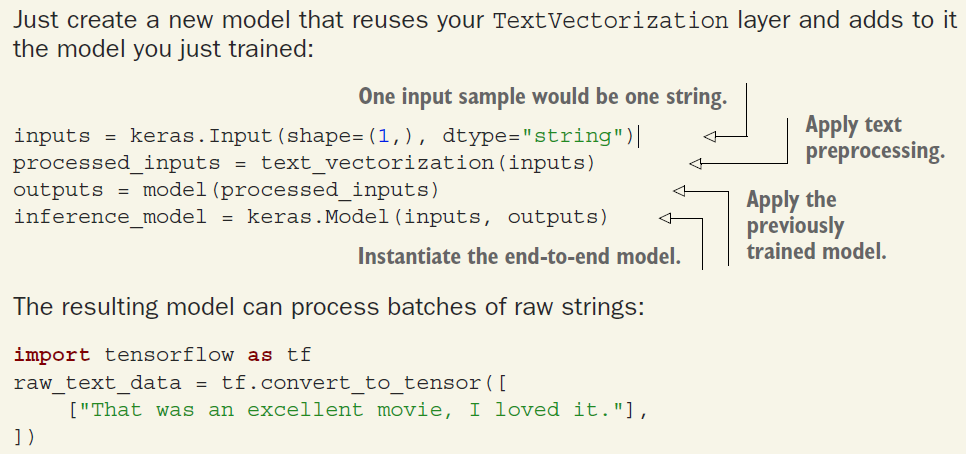

In [ ]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [ ]:
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

88.75 percent positive
